## Imports and Initialise

In [9]:
import os
import re
import csv
import json
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from openai import OpenAI
from dotenv import load_dotenv
from llm_generate import get_all_paths, get_generate_prompt, process_mwo_response, paraphrase_mwo
from llm_prompt import initialise_prompts, check_similarity

load_dotenv()
api_key = os.getenv('API_KEY')
client = OpenAI(api_key=api_key)
data, _ = get_all_paths(valid=True)

49	paths in object_property_paths
391	paths in process_agent_paths
269	paths in process_patient_paths
1209	paths in state_patient_paths
3	paths in object_property_state_paths
0	paths in object_process_state_paths
607	paths in state_agent_activity_paths
37	paths in state_agent_patient_paths
1229	paths in process_agent_patient_paths
Total number of paths: 3794


## Functions

In [6]:
def get_1fewshot_message(prompt_variations):
    """ Get fewshot message given fewshot csv file for single-example prompt """
    message = [{"role": "system", "content": "You are a technician recording maintenance work orders."}]
    with open("fewshot_messages/fewshot_one.csv", encoding='utf-8') as f:
        data = csv.reader(f)
        next(data) # Ignore header
        for row in data:
            object_name = row[0]
            event_name = f"{row[1]} {row[2]}".strip()
            prompt = get_generate_prompt(prompt_variations, object_name, event_name)
            user = {"role": "user", "content": prompt}
            assistant = {"role": "assistant", "content": row[3]}
            message.append(user)
            message.append(assistant)
    return message

def get_5fewshot_message(prompt_variations):
    """ Get fewshot message given fewshot csv file for 5-example prompt """
    message = [{"role": "system", "content": "You are a technician recording maintenance work orders."}]
    with open("fewshot_messages/fewshot_generate.csv", encoding='utf-8') as f:
        data = csv.reader(f)
        next(data) # Ignore header
        for row in data:
            object_name = row[0]
            event_name = f"{row[1]} {row[2]}".strip()
            prompt = get_generate_prompt(prompt_variations, object_name, event_name)
            user = {"role": "user", "content": prompt}
            example = f"1. {row[4]}\n2. {row[5]}\n3. {row[6]}\n4. {row[7]}\n5. {row[8]}"
            assistant = {"role": "assistant", "content": example}
            message.append(user)
            message.append(assistant)
    return message

# Print some fewshot examples from MaintIE gold dataset
def print_examples(object, event, helper=None):
    """ Print some fewshot examples from the gold dataset """
    data = []
    with open("../data/MaintIE/gold_release.json", encoding='utf-8') as f:
        gold = json.load(f)
        for d in gold:
            text = d['text'].replace("<id> ", "").replace(" <id>", "")
            data.append(text)
    for sentence in data:
        event_exists = re.search(rf'\b{event}\b', sentence)
        helper_exists = re.search(rf'\b{helper}\b', sentence) if helper else None
        if object in sentence and event_exists and helper_exists:
            print(f"{object},{event},{helper},{sentence}")
            return True
        elif object in sentence and event_exists:
            print(f"{object},{event},{sentence}")
            return True
    return False

# Process single response from the LLM
def process_single_response(response):
    """ Process single response from the LLM """
    response = response.lower()                     # Case folding
    response = re.sub(r'[^\w\s]', ' ', response)    # Remove punctuation
    response = re.sub(r"\s+", " ", response)        # Remove extra spaces
    return response

# write to outlog text file
def write_to_outlog(title, data):
    """ Write data to log text file """
    with open("mwo_sentences/path_diversity.txt", "a", encoding='utf-8') as f:
        f.write("========================================\n")
        f.write(f"{title}\n")
        f.write(f"- Number of unique: {len(data)}\n")
        for d in data:
            f.write(f"{d}\n")
        f.write("========================================\n")

In [5]:
# Print some examples from the gold dataset
successful_calls = 0
while successful_calls < 5:
    current = random.choice(data)
    if 'helper_name' in current:
        if print_examples(current['object_name'], current['event_name'], current['helper_name']):
            successful_calls += 1
    else:
        if print_examples(current['object_name'], current['event_name']):
            successful_calls += 1

air conditioner,leaking oil,air conditioner accessory drive leaking oil
oil centrifuge gasket,leaking,oil centrifuge gasket leaking right hand engine
brake pump,broken,change out broken bolt on brake pump
radio,no reception,- no reception on AM / FM radio
isolator,needs clean out,main isolator needs clean out


## Same prompt VS Variant prompts

In [7]:
path = {
        "object_name": "park brake",
        "event_name": "alarm fault",
        "valid": True,
        "alternate": False
    }
prompt_variations = initialise_prompts(client, num_variants=5, num_examples=1)
base_prompts, limit_words, limit_count = prompt_variations
for b in base_prompts:
    print(b)
for w in limit_words:
    print(w)
for c in limit_count:
    print(c)

Create a sentence for a Maintenance Work Order (MWO) that details the equipment and the undesirable event.
Formulate a sentence regarding a Maintenance Work Order (MWO) that describes the equipment involved and the undesirable event.
Draft a Maintenance Work Order (MWO) sentence outlining the equipment and the undesirable event that occurred.
Compose a sentence for a Maintenance Work Order (MWO) that addresses the equipment and the related undesirable event.
Write a sentence for a Maintenance Work Order (MWO) concerning the equipment and the undesirable event.
Minimize stop words and refrain from verbosity.
Steer clear of verbosity and limit stop words.
Limit stop words and avoid unnecessary verbosity.
Avoid verbosity and use few stop words.
Use minimal stop words and avoid verbosity.
An 8-word sentence is the maximum allowed.
A sentence can have a maximum of 8 words.
The sentence can consist of up to 8 words.
You can create a sentence with 8 words.
The maximum for a sentence is 8 word

In [8]:
# Same prompt
def same_prompt():
    outputs = []
    base_prompt = "Generate a Maintenance Work Order (MWO) sentence describing the following equipment and undesirable event."
    limit_words = "Avoid verbosity and use minimal stop words."
    limit_count = "The sentence can have a maximum of 8 words."
    prompt = f"{base_prompt}\nEquipment: {path['object_name']}\nUndesirable Event: {path['event_name']}"
    prompt += f"You must use all terms given above and do not add new information.\n{limit_words}\n{limit_count}"
    fewshot = get_1fewshot_message(([base_prompt], [limit_words], [limit_count]))
    message = fewshot + [{"role": "user", "content": prompt}]

    response = client.chat.completions.create(
                    model="gpt-4o-mini",
                    messages=message,
                    temperature=0.9,
                    top_p=0.9,
                    n=5
                )

    for choice in response.choices:
        output = choice.message.content
        output = process_single_response(output) 
        outputs.append(output)
    return outputs

In [9]:
# Variant prompts
def variant_prompt():
    outputs = []
    fewshot = get_1fewshot_message(prompt_variations)
    for _ in range(5):
        prompt = get_generate_prompt(prompt_variations, path['object_name'], path['event_name'])
        message = fewshot + [{"role": "user", "content": prompt}]
        response = client.chat.completions.create(
                        model="gpt-4o-mini",
                        messages=message,
                        temperature=0.9,
                        top_p=0.9,
                        n=1
                )

        for choice in response.choices:
            output = choice.message.content
            output = process_single_response(output)
            outputs.append(output)
    return outputs

In [7]:
# Demo
same = same_prompt()
variant = variant_prompt()

print ("GPT given same prompt:")
for s in same:
    print(f"- {s}")
print ("GPT given variant prompts:")
for v in variant:
    print(f"- {v}")

GPT given same prompt:
- park brake alarm fault detected
- park brake alarm fault detected
- park brake alarm fault
- park brake alarm fault
- park brake alarm fault
GPT given variant prompts:
- park brake has alarm fault
- park brake has alarm fault
- park brake alarm fault detected
- park brake alarm fault detected
- park brake alarm fault


In [17]:
# Compare diversity over long run
same = []
variant = []
for _ in range(20):
    same.extend(same_prompt())
    variant.extend(variant_prompt())
print (f"Number of unique responses for same prompt: {len(set(same))}")
print (f"Number of unique responses for variant prompts: {len(set(variant))}")
write_to_outlog("OUTPUT FOR SAME PROMPT", list(set(same)))
write_to_outlog("OUTPUT FOR VARIANT PROMPTS", list(set(variant)))
total = same + variant
print (f"Total number of unique responses: {len(set(total))}")

Number of unique responses for same prompt: 3
Number of unique responses for variant prompts: 3
Total number of unique responses: 3


## N completions VS N sentences in ONE completion

In [9]:
# N sentences in ONE completion
def n_sentences():
    outputs = []
    base_prompt = "Generate 5 different Maintenance Work Order (MWO) sentences describing the following equipment and undesirable event."
    limit_words = "Avoid verbosity and use minimal stop words."
    limit_count = "Each sentence can have a maximum of 8 words."
    prompt = f"{base_prompt}\nEquipment: {path['object_name']}\nUndesirable Event: {path['event_name']}"
    prompt += f"You must use all terms given above and do not add new information.\n{limit_words}\n{limit_count}"
    fewshot = get_5fewshot_message(([base_prompt], [limit_words], [limit_count]))
    message = fewshot + [{"role": "user", "content": prompt}]

    response = client.chat.completions.create(
                    model="gpt-4o-mini",
                    messages=message,
                    temperature=0.9,
                    top_p=0.9,
                    n=1
                )

    for choice in response.choices:
        output = choice.message.content
        output = process_mwo_response(output)
        for sentence in output:
            outputs.append(sentence)
    return outputs

In [10]:
# Demo
n_completion = same_prompt()
n_sentence = n_sentences()

print ("Output in N completions:")
for c in n_completion:
    print(f"- {c}")
print ("Output within 1 completion:")
for s in n_sentence:
    print(f"- {s}")

Output in N completions:
- park brake alarm fault detected
- park brake alarm fault
- park brake alarm fault
- park brake alarm fault
- park brake alarm fault detected
Output within 1 completion:
- park brake alarm fault
- alarm fault in park brake
- park brake has alarm fault
- alarm fault found in park brake
- park brake showing alarm fault


In [11]:
# Compare diversity over long run
n_completion = []
n_sentence = []
for _ in range(20):
    n_completion.extend(same_prompt())
    n_sentence.extend(n_sentences())
print (f"Number of unique responses for N completions: {len(set(n_completion))}")
print (f"Number of unique responses for ONE completion: {len(set(n_sentence))}")
write_to_outlog("OUTPUT IN N COMPLETIONS", list(set(n_completion)))
write_to_outlog("OUTPUT IN 1 COMPLETION", list(set(n_sentence)))
total_responses = n_completion + n_sentence
print (f"Total number of unique responses: {len(set(total_responses))}")

Number of unique responses for N completions: 2
Number of unique responses for ONE completion: 15
Total number of unique responses: 15


## Paraphrase VS Generation

In [12]:
# Paraphrase
def paraphrase():
    outputs = []
    base_prompt = "Generate a Maintenance Work Order (MWO) sentence describing the following equipment and undesirable event."
    limit_words = "Avoid verbosity and use minimal stop words."
    limit_count = "Each sentence can have a maximum of 8 words."
    prompt = f"{base_prompt}\nEquipment: {path['object_name']}\nUndesirable Event: {path['event_name']}"
    prompt += f"You must use all terms given above and do not add new information.\n{limit_words}\n{limit_count}"
    fewshot = get_1fewshot_message(([base_prompt], [limit_words], [limit_count]))
    message = fewshot + [{"role": "user", "content": prompt}]

    response = client.chat.completions.create(
                    model="gpt-4o-mini",
                    messages=message,
                    temperature=0.9,
                    top_p=0.9,
                    n=1
            )

    for choice in response.choices:
        output = choice.message.content
        output = process_single_response(output)
        outputs.append(output)

    keywords = [path['object_name'], path['event_name']]
    paraphrases = paraphrase_mwo(client, output, keywords, 5)
    outputs.extend(paraphrases)
    outputs = list(set(outputs)) # Remove duplicates
    return outputs[:5] # Only return 5 outputs

In [15]:
# Demo
paraphrases = paraphrase()
n_sentence = n_sentences()

print ("Output for Paraphrasing:")
for p in paraphrases:
    print(f"- {p}")
print ("Output for Generation:")
for s in n_sentence:
    print(f"- {s}")

Output for Paraphrasing:
- detected alarm fault in park brake
- park brake alarm fault detected
- park brake has alarm fault
- alarm fault detected in park brake
- alarm fault found in park brake
Output for Generation:
- park brake alarm fault
- alarm fault in park brake
- park brake has alarm fault
- park brake alarm is faulty
- faulty alarm in park brake


In [16]:
# Compare diversity over long run
paraphrases = []
n_sentence = []
for _ in range(20):
    paraphrases.extend(paraphrase())
    n_sentence.extend(n_sentences())
print (f"Number of unique responses for paraphrasing: {len(set(paraphrases))}")
print (f"Number of unique responses for generation: {len(set(n_sentence))}")
write_to_outlog("OUTPUT FOR PARAPHRASING", list(set(paraphrases)))
write_to_outlog("OUTPUT FOR GENERATION", list(set(n_sentence)))
total_responses = paraphrases + n_sentence
print (f"Total unique responses: {len(set(total_responses))}")

Number of unique responses for paraphrasing: 25
Number of unique responses for generation: 16
Total unique responses: 32


## Other Paraphraser Models

In [34]:
import torch
import warnings
warnings.filterwarnings("ignore")

def format_data():
    finetune_data = []
    with open('fewshot_messages/fewshot.csv', 'r', encoding='utf-8') as f:
        data = csv.reader(f)
        next(data) # Ignore header
        for row in data:
            if len(row) > 4:
                original = row[3]
                example = [row[4], row[5], row[6], row[7]]
                for e in example:
                    temp = {
                        "source": original, 
                        "target": e
                    }
                    finetune_data.append(temp)
                    
    finetune_train = finetune_data[:int(0.8*len(finetune_data))]
    finetune_val = finetune_data[int(0.8*len(finetune_data)):]
    with open('fewshot_messages/train.json', 'w', encoding='utf-8') as f:
        json.dump(finetune_train, f, indent=4)
    with open('fewshot_messages/val.json', 'w', encoding='utf-8') as f:
        json.dump(finetune_val, f, indent=4)

# Transformer model for paraphrasing
def model_paraphrase(model, tokenizer, sentence):
    input_ids = tokenizer(
        f'paraphrase: {sentence}',
        return_tensors="pt", padding="longest",
        max_length=25, truncation=True).input_ids.to(device)
    outputs = model.generate(
        input_ids, temperature=0.7, repetition_penalty=10.0,
        num_return_sequences=5, no_repeat_ngram_size=2,
        num_beams=5, num_beam_groups=5,
        max_length=25, diversity_penalty=3.0
    )
    res = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    return res

def paraphrase_sentences(tokenizer, model, sentences):
    outputs = {}
    for sentence in sentences:
        batch = tokenizer([sentence],truncation=True,padding='longest',max_length=25, return_tensors="pt").to(device)
        paraphrased = model.generate(**batch, temperature=0.7, repetition_penalty=10.0,
                                        num_return_sequences=5, no_repeat_ngram_size=2,
                                        num_beams=5, num_beam_groups=5,
                                        max_length=25, diversity_penalty=3.0
                                    )
        output = tokenizer.batch_decode(paraphrased, skip_special_tokens=True)
        outputs[sentence] = output
    return outputs

format_data()

sentences = ["park brake alarm fault detected",
             "alarm fault in park brake system",
             "park brake has alarm fault",
             "park brake system shows alarm fault",
             "alarm fault present in park brake",
             "The boy is walking happily on the street"]    

## BART Paraphrase Model

In [36]:
# https://huggingface.co/eugenesiow/bart-paraphrase
from transformers import BartForConditionalGeneration, BartTokenizer

bart_model = BartForConditionalGeneration.from_pretrained('eugenesiow/bart-paraphrase')
bart_tokenizer = BartTokenizer.from_pretrained('eugenesiow/bart-paraphrase')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bart_model = bart_model.to(device)

bart_outputs = paraphrase_sentences(bart_tokenizer, bart_model, sentences)

print("BART Outputs:")
for sentence, outputs in bart_outputs.items():
    print(f"{sentence}:")
    for output in outputs:
        print(f"- {output}")

BART Outputs:
park brake alarm fault detected:
- Park brake alarm fault detected
- The alarm fault was detected in the park brake.
- park Brake alarm fault detected.
- Brake brake alarm Fault detected
- Park brake alarm Fault detect
alarm fault in park brake system:
- Alarm Fault in park brake system?
- What is the cause of an alarm fault in a park brake system?
- The alarm fault is in park brake system.
- In park brake system, alarm fault is not fixed.
- System Fault in park brake system?
park brake has alarm fault:
- Park brake has alarm fault. How can it be fixed?
- The park brake has alarm fault. How can it be fixed?
- What is the cause of a brake alarm fault?
- Park brakes have an alarm fault. What should I do to fix it?
- park brake has alarm faults, it is not working.
park brake system shows alarm fault:
- Park brake system shows alarm fault.
- The park brake system shows alarm fault.
- Park brakes show alarm fault. How can this be fixed?
- A parking brake system shows an alarm 

## T5 Paraphrase Model

In [32]:
# https://huggingface.co/ramsrigouthamg/t5_sentence_paraphraser
from transformers import T5ForConditionalGeneration,T5Tokenizer

t5_sent_model = T5ForConditionalGeneration.from_pretrained("ramsrigouthamg/t5_sentence_paraphraser")
t5_sent_tokenizer = T5Tokenizer.from_pretrained("ramsrigouthamg/t5_sentence_paraphraser")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
t5_sent_model = t5_sent_model.to(device)

for sentence in sentences:
    outputs = model_paraphrase(t5_sent_model, t5_sent_tokenizer, sentence)
    print(f"{sentence}:")
    for output in outputs:
        print(f"- {output.removeprefix('paraphrasedoutput: ')}")

park brake alarm fault detected:
- A park brake warning error has been found.
- An accident has been reported with the park brake alert.
- There has been a problem with the park brake alert system.
- A parking brake alarm fault was detected.
- The park brake alert system is running fine, but it has been detected.
alarm fault in park brake system:
- An alarm is raised in the park brake system.
- An alarm system in the park brake system is failing.
- There is an error in the park brake system that causes this alert.
- an error occurred in the park brake system, causing an alarm.
- In the park brake system, an alarm clock malfunctions.
park brake has alarm fault:
- The park brake has an alarm clock fault.
- The park brake has an error, according to the driver.
- A security issue with the park brake has been fixed.
- An alarm is triggered by the park brake.
- If the park brake has an error, it is possible to fix it.
park brake system shows alarm fault:
- The park brake system is showing an

## ChatGPT Paraphrase T5

In [13]:
# https://huggingface.co/humarin/chatgpt_paraphraser_on_T5_base
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

chat_tokenizer = AutoTokenizer.from_pretrained("humarin/chatgpt_paraphraser_on_T5_base")
chat_model = AutoModelForSeq2SeqLM.from_pretrained("humarin/chatgpt_paraphraser_on_T5_base").to(device)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
chat_model = chat_model.to(device)

for sentence in sentences:
    outputs = model_paraphrase(chat_model, chat_tokenizer, sentence)
    print(f"{sentence}:")
    for output in outputs:
        print(f"- {output}")

park brake alarm fault detected:
- A fault in the park brake alarm has been identified.
- Detection of a fault in the park brake alarm system
- The park brake alarm has been deemed defective.
- An error has been identified in the park brake alarm's functionality.
- Park brake alarm faulty, please.
alarm fault in park brake system:
- An alarm failure has been detected in the park brake system.
- The park brake system has been deemed to be defective due to an
- A faulty alarm in the parking brake system has been detected.
- There is an alarm failure in the park brake system.
- Park brakes issue alarm
park brake has alarm fault:
- The park brake is experiencing an alarm failure.
- Alarm jamming on park brake
- Park brake with alarm faulty.
- An alarm is malfunctioning on the park brake.
- Alarm caliper failing on park brake.
park brake system shows alarm fault:
- The alarm is malfunctioning on the park brake system.
- Alarm triggered by park brake system.
- Alarm failure occurs in the par

## Parrot Paraphrase Model T5

In [6]:
# https://huggingface.co/prithivida/parrot_paraphraser_on_T5
from parrot import Parrot

parrot = Parrot(model_tag="prithivida/parrot_paraphraser_on_T5", use_gpu=False)

for sentence in sentences:
    print(sentence)
    paraphrases = parrot.augment(input_phrase=sentence,
                                diversity_ranker="levenshtein",
                                do_diverse=True, 
                                max_return_phrases=5, 
                                max_length=8)
    if paraphrases:
        for p in paraphrases:
            print(f"- {p}")
    else:
        print("No paraphrases found.")

park brake alarm fault detected
- ('park brake alarm fault detected', 0)
alarm fault in park brake system
- ('warning of a fault in the brake system', 17)
park brake has alarm fault
No paraphrases found.
park brake system shows alarm fault
- ('the park brakes system shows an alarm fault', 13)
alarm fault present in park brake
- ('warning of a fault in the park brake', 22)
The boy is walking happily on the street
- ('a happy boy walks along the streets', 26)
- ('he walks happily on the street', 23)
- ('the boy walks happily in the street', 19)
- ('the boy walks happily on the street', 18)
- ('the boy is walking happily on the street', 12)


## PEGASUS fine-tuned for Paraphrasing

In [15]:
# https://huggingface.co/tuner007/pegasus_paraphrase
from transformers import PegasusForConditionalGeneration, PegasusTokenizer

pegasus_model = PegasusForConditionalGeneration.from_pretrained("tuner007/pegasus_paraphrase")
pegasus_tokenizer = PegasusTokenizer.from_pretrained("tuner007/pegasus_paraphrase")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pegasus_model = pegasus_model.to(device)

for sentence in sentences:
    outputs = model_paraphrase(pegasus_model, pegasus_tokenizer, sentence)
    print(f"{sentence}:")
    for output in outputs:
        print(f"- {output}")

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at tuner007/pegasus_paraphrase and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


park brake alarm fault detected:
- The park brake alarm fault was detected.
- Park brake alarm fault detected.
- A fault with the park brake alarm has been detected.
- There is a park brake alarm fault
- Park brakes fault detected.
alarm fault in park brake system:
- There is an alarm fault in the park brake system.
- The alarm fault in the park brake system.
- Park brake system has an alarm fault.
- It was a fault in the park brake system.
- A fault in the park brake system was cited.
park brake has alarm fault:
- The park brake has an alarm fault.
- Park brake has an alarm fault.
- There is an alarm fault with the park brake.
- The alarm fault is on the park brake.
- A park brake has a problem
park brake system shows alarm fault:
- The park brake system has an alarm fault.
- Park brake system shows alarm fault.
- There is an alarm fault in the park brake system.
- A park brakes alarm shows a fault.
- The Park Brake System shows alarm fault
alarm fault present in park brake:
- There i

## Temperature and Top-p Parameter Sensitivity Analysis

In [7]:
temperature_values = [0.0, 0.15, 0.3, 0.45, 0.6, 0.75, 0.9, 1.05, 1.2, 1.35, 1.5, 1.65, 1.8, 2.0]
top_p_values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Generate a sentence per completion 5 times using a given temperature and top-p value
def test_parameters(temperature, top_p):
    outputs = []
    base_prompt = "Generate 5 different Maintenance Work Order (MWO) sentences describing the following equipment and undesirable event."
    limit_words = "Avoid verbosity and use minimal stop words."
    limit_count = "Each sentence can have a maximum of 8 words."
    prompt = f"{base_prompt}\nEquipment: {path['object_name']}\nUndesirable Event: {path['event_name']}"
    prompt += f"You must use all terms given above and do not add new information.\n{limit_words}\n{limit_count}"
    fewshot = get_5fewshot_message(([base_prompt], [limit_words], [limit_count]))
    message = fewshot + [{"role": "user", "content": prompt}]

    response = client.chat.completions.create(
                    model="gpt-4o-mini",
                    messages=message,
                    temperature=0.9,
                    top_p=0.9,
                    n=1
                )

    for choice in response.choices:
        output = choice.message.content
        output = process_mwo_response(output)
        for sentence in output:
            outputs.append(sentence)
    return outputs

In [10]:
path = {
        "object_name": "park brake",
        "event_name": "alarm fault",
        "valid": True,
        "alternate": False
    }

num_trials = 5
results = []

current_combination = 0
total_combinations = len(temperature_values) * len(top_p_values)

for temp in temperature_values:
    for top_p in top_p_values:
        for trial in range(num_trials):
            outputs = test_parameters(temp, top_p)
            for output in outputs:
                results.append({"Temperature": temp, "Top-p": top_p, "MWO Output": output})
        
        current_combination += 1
        print(f"[{current_combination}/{total_combinations}] Completed temperature={temp}, top-p={top_p}")

df = pd.DataFrame(results)
df.to_csv('output/temp_top-p_sensitivity.csv', index=False)
print(df)
print("Saved to output/temp_top-p_sensitivity.csv")

[1/154] Completed temperature=0.0, top-p=0.0
[2/154] Completed temperature=0.0, top-p=0.1
[3/154] Completed temperature=0.0, top-p=0.2
[4/154] Completed temperature=0.0, top-p=0.3
[5/154] Completed temperature=0.0, top-p=0.4
[6/154] Completed temperature=0.0, top-p=0.5
[7/154] Completed temperature=0.0, top-p=0.6
[8/154] Completed temperature=0.0, top-p=0.7
[9/154] Completed temperature=0.0, top-p=0.8
[10/154] Completed temperature=0.0, top-p=0.9
[11/154] Completed temperature=0.0, top-p=1.0
[12/154] Completed temperature=0.15, top-p=0.0
[13/154] Completed temperature=0.15, top-p=0.1
[14/154] Completed temperature=0.15, top-p=0.2
[15/154] Completed temperature=0.15, top-p=0.3
[16/154] Completed temperature=0.15, top-p=0.4
[17/154] Completed temperature=0.15, top-p=0.5
[18/154] Completed temperature=0.15, top-p=0.6
[19/154] Completed temperature=0.15, top-p=0.7
[20/154] Completed temperature=0.15, top-p=0.8
[21/154] Completed temperature=0.15, top-p=0.9
[22/154] Completed temperature=0.

### Unique Outputs Analysis

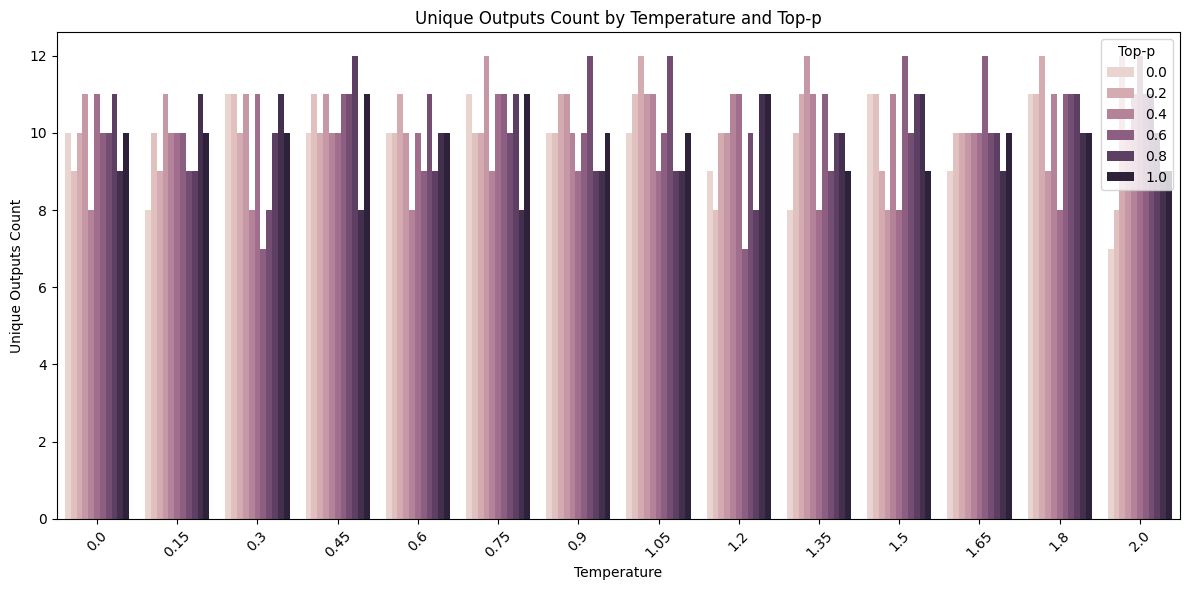

In [11]:
unique_outputs_df = df.groupby(['Temperature', 'Top-p'])['MWO Output'].nunique().reset_index()
unique_outputs_df.to_csv('output/unique_outputs_count.csv', index=False)
unique_outputs_df.columns = ['Temperature', 'Top-p', 'Unique Outputs Count']

# Plotting Unique Outputs Count
plt.figure(figsize=(12, 6))
sns.barplot(data=unique_outputs_df, x='Temperature', y='Unique Outputs Count', hue='Top-p')
plt.title('Unique Outputs Count by Temperature and Top-p')
plt.xlabel('Temperature')
plt.ylabel('Unique Outputs Count')
plt.legend(title='Top-p')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Unique Tokens Analysis

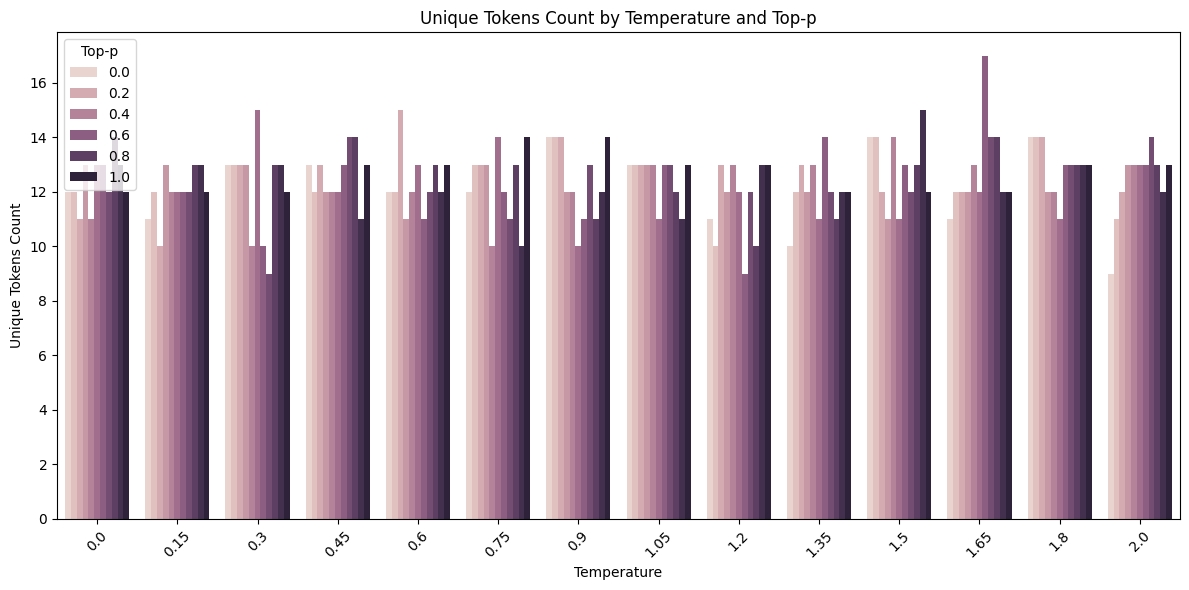

In [12]:
def count_unique_tokens(results_df):
    unique_token_counts = []
    grouped = results_df.groupby(['Temperature', 'Top-p'])['MWO Output'].apply(list).reset_index()
    for _, row in grouped.iterrows():
        combined_outputs = ' '.join(row['MWO Output'])
        tokens = set(combined_outputs.split())
        unique_token_count = len(tokens)
        unique_token_counts.append({
            'Temperature': row['Temperature'],
            'Top-p': row['Top-p'],
            'Unique Token Count': unique_token_count
        })

    unique_tokens_df = pd.DataFrame(unique_token_counts)
    return unique_tokens_df

unique_tokens_df = count_unique_tokens(df)
unique_tokens_df.to_csv('output/unique_tokens_count.csv', index=False)
unique_tokens_df.columns = ['Temperature', 'Top-p', 'Unique Token Count']

# Plotting Unique Tokens Count
plt.figure(figsize=(12, 6))
sns.barplot(data=unique_tokens_df, x='Temperature', y='Unique Token Count', hue='Top-p')
plt.title('Unique Tokens Count by Temperature and Top-p')
plt.xlabel('Temperature')
plt.ylabel('Unique Tokens Count')
plt.legend(title='Top-p')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Overlapping Tokens Analysis

Overlapping tokens:  {'brake', 'has', 'fault', 'alarm', 'in', 'park'}
Vocabulary length: 30


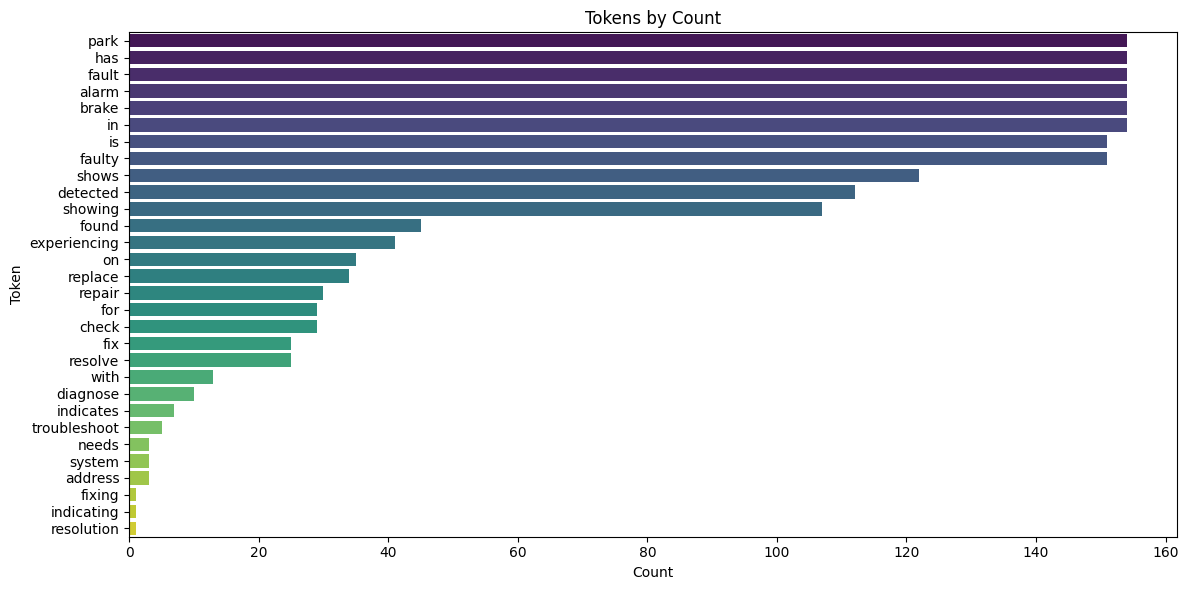

In [40]:
def token_occurrences(results_df):
    grouped = results_df.groupby(['Temperature', 'Top-p'])['MWO Output'].apply(list).reset_index()
    
    common_tokens = None
    token_counts = {}
    for _, row in grouped.iterrows():
        combined_outputs = ' '.join(row['MWO Output'])
        tokens = set(combined_outputs.split())

        if common_tokens is None:
            common_tokens = tokens
        else:
            common_tokens.intersection_update(tokens) 
            
        for token in tokens:
            if token not in token_counts:
                token_counts[token] = 0
            token_counts[token] += 1
    return common_tokens, token_counts

common_tokens, token_counts = token_occurrences(df)
token_counts_df = pd.DataFrame(list(token_counts.items()), columns=['Token', 'Count'])
token_counts_df = token_counts_df.sort_values(by='Count', ascending=False)

print("Overlapping tokens: ", common_tokens)
print("Vocabulary length:", len(token_counts))

plt.figure(figsize=(12, 6))
sns.barplot(data=token_counts_df, x='Count', y='Token', palette='viridis', hue='Token', legend=False)
plt.title('Tokens by Count')
plt.xlabel('Count')
plt.ylabel('Token')
plt.tight_layout()
plt.show()

In [51]:
def find_least_occurred_words(token_counts, results_df, n=10):
    least_occurred_words = sorted(token_counts.items(), key=lambda item: item[1])
    
    results = []
    for token, count in least_occurred_words[:n]:
        combinations = results_df[results_df['MWO Output'].str.contains(token, na=False)]
        settings = combinations[['Temperature', 'Top-p']].drop_duplicates()
        
        results.append({
            'Token': token,
            'Count': count,
            'Combinations (Temperature, Top-p)': settings.values.tolist()
        })

    return results

least_occurred_results = find_least_occurred_words(token_counts, df, n=10)

least_occurred_df = pd.DataFrame(least_occurred_results)
print(least_occurred_df)
least_occurred_df.to_csv('output/least_occurred_words.csv', index=False)

          Token  Count                  Combinations (Temperature, Top-p)
0        fixing      1                                      [[1.65, 0.6]]
1    indicating      1                                       [[2.0, 0.7]]
2    resolution      1                                       [[2.0, 1.0]]
3         needs      3              [[0.0, 0.3], [1.65, 0.6], [2.0, 1.0]]
4       address      3              [[0.0, 0.8], [0.45, 0.2], [1.8, 0.0]]
5        system      3              [[0.15, 0.7], [1.8, 0.1], [2.0, 0.5]]
6  troubleshoot      5  [[0.0, 0.6], [0.45, 0.7], [0.45, 0.9], [0.6, 1...
7     indicates      7  [[0.45, 0.5], [0.75, 0.5], [0.75, 1.0], [0.9, ...
8      diagnose     10  [[0.3, 0.3], [0.6, 0.2], [0.6, 0.3], [0.9, 0.8...
9          with     13  [[0.6, 0.3], [0.6, 0.5], [0.6, 0.9], [0.9, 0.1...


## Overall Generation Process
For generating sentences for ONE path, we can use the following process:
1. Use multiple **prompt variations**
2. Generate **multiple sentences** for each completion using a random prompt
3. Generate **paraphrases** for each generated sentence

In [24]:
# Generate 100 random sentences using diverse
base_prompts, limit_words, limit_count = initialise_prompts(client, num_variants=5, num_examples=5)
paths_sample = random.sample(data, 100)
sentences_sample = []

# Generate sentences for paths
for i, path in enumerate(paths_sample):
    # Variant prompt
    prompt = get_generate_prompt(base_prompts, limit_words, limit_count, path['object_name'], path['event_name'])
    keywords = [path['object_name'], path['event_name']]
    fewshot = get_5fewshot_message(base_prompts, limit_words, limit_count)
    message = fewshot + [{"role": "user", "content": prompt}]

    # Generation
    sentences = []
    response = client.chat.completions.create(
                    model="gpt-4o-mini",
                    messages=message,
                    temperature=0.9,
                    top_p=0.9,
                    n=1
                )
    response_sentences = process_mwo_response(response.choices[0].message.content)
    sentences.extend(response_sentences)
    sentences = list(set(sentences)) # Remove duplicates

    # Paraphrase
    paraphrases = []
    chosen_sentence = random.choice(sentences)
    response_paraphrases = paraphrase_mwo(client, chosen_sentence, keywords, 5)
    response_similarities = check_similarity(chosen_sentence, response_paraphrases)
    for para, sim in zip(response_paraphrases, response_similarities):
        if sim > 0.9:
            paraphrases.append(para)
    paraphrases = list(set(paraphrases)) # Remove duplicates

    # Combine
    sentences.extend(paraphrases)
    sentences = list(set(sentences)) # Remove duplicates
    sentences_sample.append(random.choice(sentences))
    
    # Print progress status every 25 paths
    if (i+1) % 25 == 0:
        print(f"Completed {i+1} paths")

# Append to text file
with open('TuringTest/synthetic_generate.txt', 'a', encoding='utf-8') as f:
    for sentence in sentences_sample:
        f.write(f"{sentence}\n")

Completed 25 paths
Completed 50 paths
Completed 75 paths
Completed 100 paths
